In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

if os.getcwd().endswith('notebooks'):
    os.chdir('..')


In [182]:
def load_data(year, split):
  data = []
  for entry in os.scandir(f'./data/Ohio{year}_processed/{split}'):
    if not entry.is_file() or not entry.name.endswith('.csv'):
      continue

    subject = int(entry.name.split('-')[0])
    data_subject = pd.read_csv(entry)
    data_subject['year'] = year
    data_subject['split'] = split
    data_subject['subject'] = subject
    # data_subject = data_subject.set_index('5minute_intervals_timestamp')
    # data['5minute_intervals_timestamp'] = pd.to_datetime(data['5minute_intervals_timestamp'], unit='s')
    data.append(data_subject)

  return pd.concat(data)

In [183]:
data = pd.concat([load_data(2018, 'train'), load_data(2020, 'train')])
data['5minute_intervals_timestamp'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(data['5minute_intervals_timestamp'] * 5, unit='m')
data

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus,year,split,subject
0,2021-09-13 12:33:00.000000000,0.0,219.0,NaN,NaN,NaN,NaN,NaN,NaN,2018,train,563
1,2021-09-13 12:38:00.036652386,0.0,229.0,NaN,NaN,NaN,NaN,NaN,NaN,2018,train,563
2,2021-09-13 12:43:00.073304772,0.0,224.0,NaN,NaN,NaN,NaN,NaN,NaN,2018,train,563
3,2021-09-13 12:48:00.109957158,0.0,221.0,NaN,NaN,NaN,NaN,NaN,NaN,2018,train,563
4,2021-09-13 12:53:00.146609544,0.0,215.0,NaN,NaN,NaN,NaN,NaN,NaN,2018,train,563
...,...,...,...,...,...,...,...,...,...,...,...,...
13624,2027-05-26 23:43:59.841502680,0.0,170.0,NaN,0.45,NaN,NaN,NaN,NaN,2020,train,596
13625,2027-05-26 23:48:59.881126956,0.0,172.0,NaN,0.45,NaN,NaN,NaN,NaN,2020,train,596
13626,2027-05-26 23:53:59.920751226,0.0,173.0,NaN,0.45,NaN,NaN,NaN,NaN,2020,train,596
13627,2027-05-26 23:58:59.960375724,0.0,174.0,NaN,0.45,NaN,NaN,NaN,NaN,2020,train,596


In [184]:
data.isna().sum(axis=0)
# gsr = galvanic skin response

5minute_intervals_timestamp         0
missing_cbg                         0
cbg                             18251
finger                         149252
basal                            1290
hr                              82282
gsr                             35157
carbInput                      151265
bolus                          150093
year                                0
split                               0
subject                             0
dtype: int64

In [185]:
print(data['missing_cbg'].value_counts())
data['missing_cbg'] = data['missing_cbg'].astype(bool)
print(data['missing_cbg'].value_counts())


missing_cbg
0.0    134788
1.0     18251
Name: count, dtype: int64
missing_cbg
False    134788
True      18251
Name: count, dtype: int64


In [186]:
(data['cbg'].isna() != data['missing_cbg']).sum()

np.int64(0)

In [187]:
(data['bolus'].isna() != data['carbInput'].isna()).sum()

np.int64(3948)

In [188]:
data.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       13619, 13620, 13621, 13622, 13623, 13624, 13625, 13626, 13627, 13628],
      dtype='int64', length=153039)

In [110]:
ts_data = data.reset_index()
ts_data['prev_timestamp'] = ts_data.groupby('subject')['5minute_intervals_timestamp'].shift(1)
ts_data = ts_data.dropna(subset='prev_timestamp')
(ts_data['5minute_intervals_timestamp'] - ts_data['prev_timestamp']).describe()

count    153027.000000
mean          1.000117
std           0.000021
min           1.000080
25%           1.000107
50%           1.000121
75%           1.000132
max           1.000149
dtype: float64

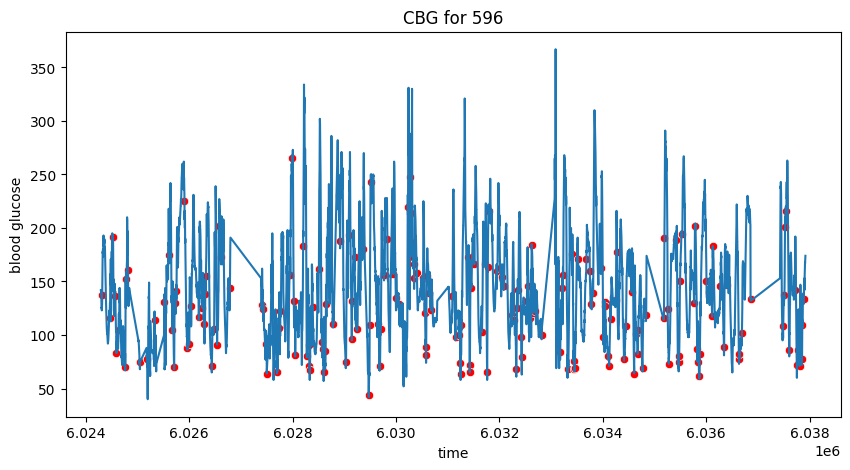

In [111]:
subject_data = data[data['subject'] == 596]
filtered_subject_data = subject_data[~subject_data['carbInput'].isna()]
plt.figure(figsize = (10, 5))
sns.lineplot(subject_data, x=subject_data.index, y='cbg')
sns.scatterplot(filtered_subject_data, x=filtered_subject_data.index, y='cbg', c='red')
plt.title('CBG for 596')
plt.xlabel('time')
plt.ylabel('blood glucose')
plt.show()

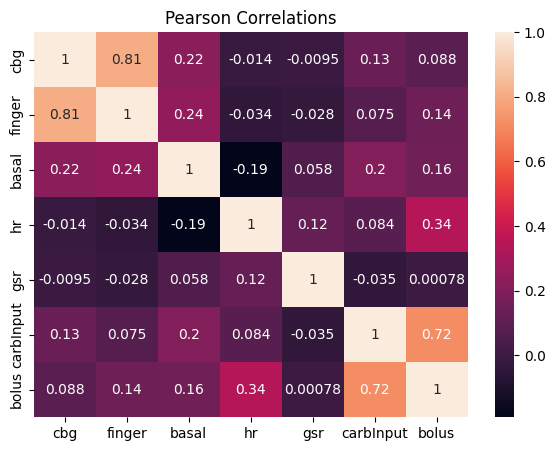

In [112]:
corr = data[['cbg', 'finger', 'basal', 'hr', 'gsr', 'carbInput', 'bolus']].corr()

plt.figure(figsize = (7, 5))
sns.heatmap(corr, annot=True)
plt.title('Pearson Correlations')
plt.xlabel('')
plt.ylabel('')
plt.show()

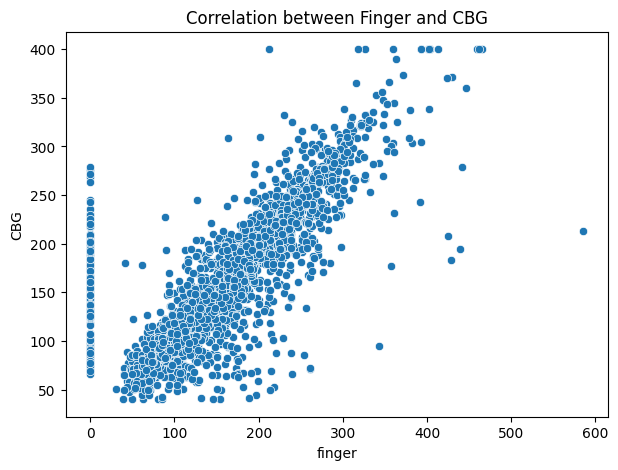

In [113]:
plt.figure(figsize = (7, 5))
sns.scatterplot(data, x='finger', y='cbg')
plt.title('Correlation between Finger and CBG')
plt.xlabel('finger')
plt.ylabel('CBG')
plt.show()

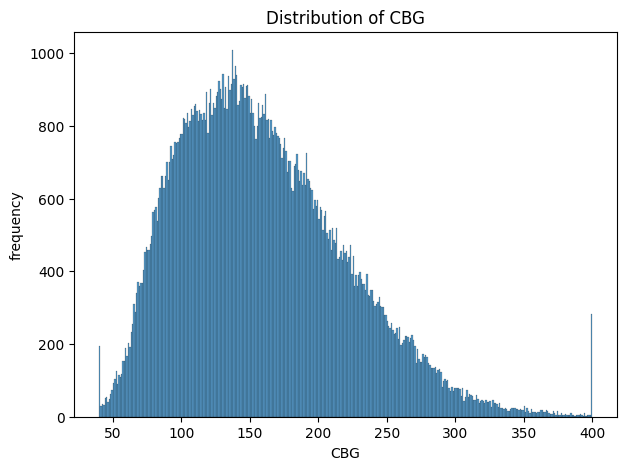

In [114]:
plt.figure(figsize = (7, 5))
sns.histplot(data['cbg'], binwidth=1)
plt.title('Distribution of CBG')
plt.xlabel('CBG')
plt.ylabel('frequency')
plt.show()

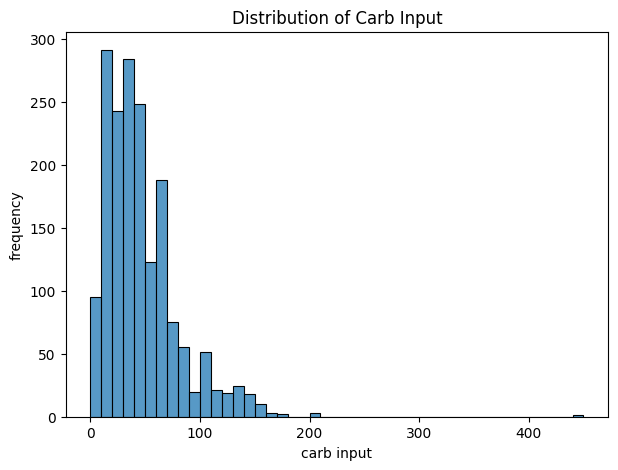

In [115]:
plt.figure(figsize = (7, 5))
sns.histplot(data['carbInput'], binwidth=10)
plt.title('Distribution of Carb Input')
plt.xlabel('carb input')
plt.ylabel('frequency')
plt.show()

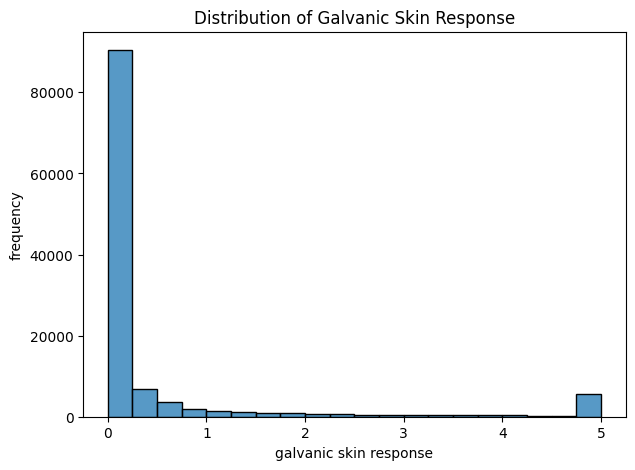

In [135]:
plt.figure(figsize = (7, 5))
sns.histplot(np.clip(data['gsr'], 0, 5), bins=20)
plt.title('Distribution of Galvanic Skin Response')
plt.xlabel('galvanic skin response')
plt.ylabel('frequency')
plt.show()

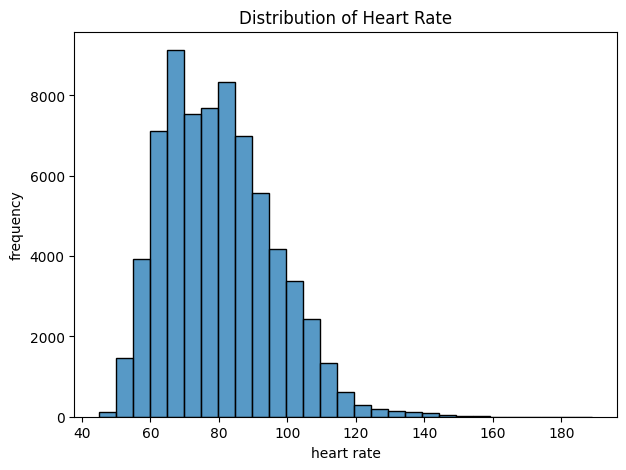

In [143]:
plt.figure(figsize = (7, 5))
sns.histplot(data['hr'], binwidth=5)
plt.title('Distribution of Heart Rate')
plt.xlabel('heart rate')
plt.ylabel('frequency')
plt.show()

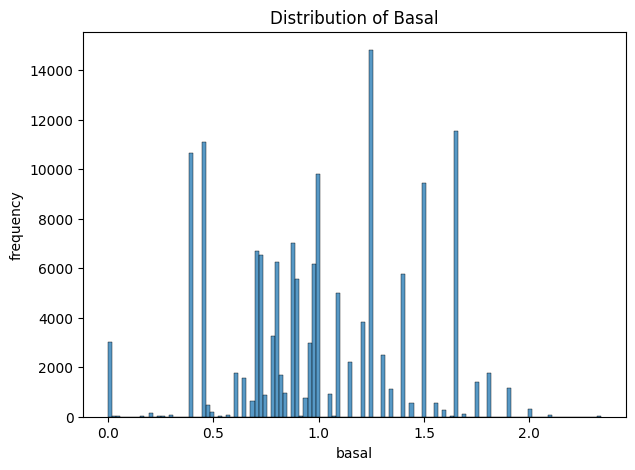

In [165]:
plt.figure(figsize = (7, 5))
sns.histplot(data['basal'])
plt.title('Distribution of Basal')
plt.xlabel('basal')
plt.ylabel('frequency')
plt.show()

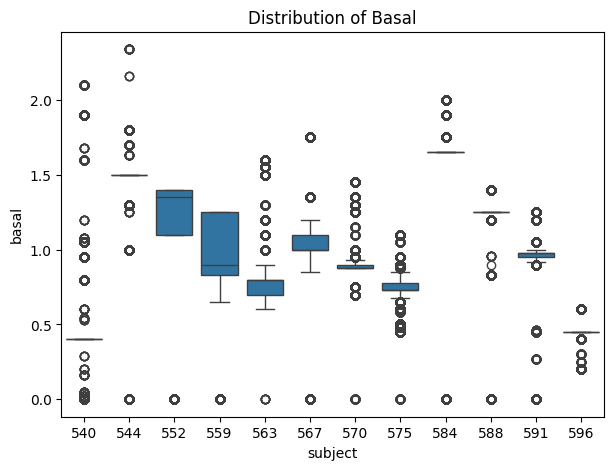

In [163]:
plt.figure(figsize = (7, 5))
sns.boxplot(data, x='subject', y='basal')
plt.title('Distribution of Basal')
plt.xlabel('subject')
plt.ylabel('basal')
plt.show()

In [141]:
data['gsr'].isna().groupby(data['subject']).sum() / data.groupby('subject').size()

subject
540    0.543749
544    0.118854
552    0.534559
559    0.055877
563    0.118882
567    0.396380
570    0.025062
575    0.080821
584    0.284593
588    0.033575
591    0.097766
596    0.453958
dtype: float64

In [144]:
data['hr'].isna().groupby(data['subject']).sum() / data.groupby('subject').size()

subject
540    1.000000
544    1.000000
552    1.000000
559    0.048675
563    0.118119
567    1.000000
570    0.023168
575    0.073647
584    1.000000
588    0.029836
591    0.096746
596    1.000000
dtype: float64

In [167]:
data['basal'].isna().groupby(data['subject']).sum() / data.groupby('subject').size()

subject
540    0.001526
544    0.000000
552    0.011535
559    0.002649
563    0.004963
567    0.000000
570    0.000517
575    0.000840
584    0.000000
588    0.003739
591    0.001725
596    0.070218
dtype: float64

In [120]:
comparison_data = data.groupby('year').describe()
comparison_data['cbg']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,69255.0,160.130012,60.538026,40.0,114.0,153.0,200.0,400.0
2020,65533.0,157.700609,60.882188,40.0,112.0,149.0,193.0,400.0


In [121]:
comparison_data['finger']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,2162.0,165.205828,72.278657,31.0,110.0,155.0,207.0,586.0
2020,1625.0,147.507692,78.493905,0.0,99.0,143.0,196.0,462.0


In [122]:
comparison_data['basal']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,75566.0,0.938846,0.256424,0.0,0.75,0.9,1.2,1.60
2020,76183.0,1.060776,0.523980,0.0,0.45,1.1,1.5,2.34


In [123]:
comparison_data['hr']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,70757.0,79.853682,16.030767,45.0,67.0,79.0,90.0,189.0
2020,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
comparison_data['gsr']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,70482.0,0.681556,2.810497,0.000041,0.000067,0.000100,0.001612,29.420000
2020,47400.0,1.123077,4.094400,0.000000,0.031110,0.123742,0.561424,75.074359


In [125]:
comparison_data['carbInput']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,1088.0,42.581801,34.231647,0.0,20.0,35.0,50.0,450.0
2020,686.0,48.164723,31.566507,1.0,24.0,42.0,64.0,162.0


In [126]:
comparison_data['bolus']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2018,1419.0,5.402396,3.425344,0.0,2.7,4.7,7.5,24.7
2020,1527.0,6.535396,5.053539,0.1,2.6,5.0,9.2,25.0


In [179]:
cleaned_data = data.drop(columns=['finger', 'hr'])
cleaned_data['carbInput'] = cleaned_data['carbInput'].fillna(0)
cleaned_data['bolus'] = cleaned_data['bolus'].fillna(0)
cleaned_data['basal'] = cleaned_data.groupby('subject')['basal'].transform(lambda x: x.fillna(x.median()))
cleaned_data['gsr'] = cleaned_data['gsr'].fillna(0) # median
cleaned_data['cbg'] = cleaned_data['cbg'].interpolate('linear')
# todo add time of day

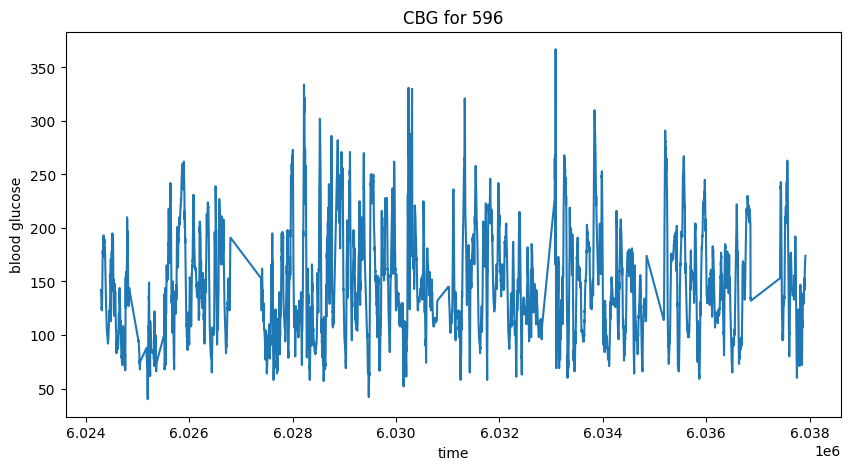

In [180]:
subject_data = cleaned_data[cleaned_data['subject'] == 596]
plt.figure(figsize = (10, 5))
sns.lineplot(subject_data, x=subject_data.index, y='cbg')
plt.title('CBG for 596')
plt.xlabel('time')
plt.ylabel('blood glucose')
plt.show()

In [176]:
cleaned_data.isna().sum(axis=0)

missing_cbg    0
cbg            0
basal          0
gsr            0
carbInput      0
bolus          0
year           0
split          0
subject        0
dtype: int64

In [117]:
# TODO check differences between 2018 and 2020
# TODO impute